Dans cette ce cours, nous allons construire notre premier réseau de neurones à partir de la library [micrograd](https://github.com/karpathy/micrograd/tree/master) qui est une library permettant le calcul automatique des gradients. Il est conseillé de comprendre les éléments de la library à partir de la traduction proposée dans le dossier MicrogradFR ou de la [vidéo d'introduction](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4s&ab_channel=AndrejKarpathy) de Andrej Karpathy (en anglais).   
Ce notebook s'inspire également du notebook présent dans le repository de micrograd. 

## Mon premier réseau de neurones 

In [1]:
#!pip install micrograd # uncomment to install micrograd
import random
import numpy as np 
import matplotlib.pyplot as plt
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

Pour construire un réseau de neurones, nous avons d'abord besoin d'un problème. Pour cela, nous utilisons la fonction [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) de scikit-learn qui permet de créer un dataset.   
Notons qu'il est nécessaire de faire un changement de variable pour y car la classe MLP de micrograd utilise une fonction d'activation [tanh](https://fr.wikipedia.org/wiki/Tangente_hyperbolique) et non une sigmoïde. La sortie du réseau est donc une valeur entre -1 et 1.  
### TODO REVOIR CA, pas sur pour la tanh

### Initialisation du dataset

Les données d'entrée sont de la forme :  [-0.81882941  0.05879006]


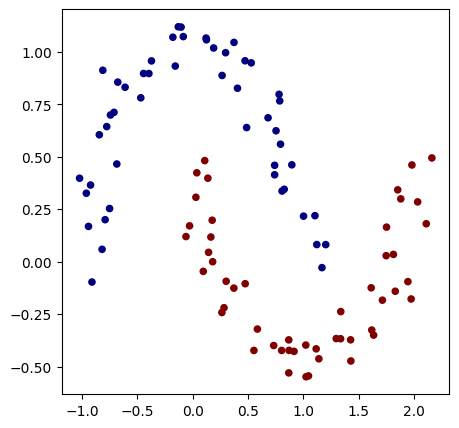

In [2]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1) # 100 éléments et un bruit Gaussien d'écart type 0.1 ajouté sur les données 

print("Les données d'entrée sont de la forme : ",X[1])

y = y*2 - 1 # Pour avoir y=-1 ou y=1 (au lieu de 0 et 1)

# Visualisation des données en 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Création du réseau de neurones

Maintenant, on va initialiser notre réseau de neurones. Notre réseau prend 2 valeurs en entrée et doit nous ressortir un label -1 ou 1.  
Le réseau de neurones que l'on va construire contient 2 couches cachées de 16 neurones chacune.  
Voici un aperçu de l'architecture de ce réseau :  
<img src="images/Mlp.png" alt="Neurone artificiel" width="300"/>

In [3]:
# Initialisation du modèle 
model = MLP(2, [16, 16, 1]) # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Nombre de paramètres 337


### Descente de gradient stochastique (SGD)

Avant de passer à la suite de notre code, il est nécessaire de faire un point sur la descente de gradient stochastique.  
Pour appliquer l'algorithme de descente de gradient sur un dataset de taille $N$, il faudrait en théorie calculer la perte sur chacun des éléments avant de calculer le gradient et de mettre à jour les poids. Cette méthode a l'avantage de garantir une diminution de la perte à chaque itération de l'entraînement mais est très couteuse pour des datasets où $N$ est grand. En pratique, on a souvent $N>10⁶$. De plus, il faudrait garder les valeurs des gradients de l'ensemble des $N$ éléments en mémoire ce qui est impossible pour des ensembles de données trop important.    
Pour palier à ce problème, nous utilisons des mini-batch qui correspondent à des groupes d'échantillons du dataset. L'optimisation se fait de la même manière que sur la descente de gradient sauf que la mise à jour des poids se fait à chaque mini-batch. Le processus d'optimisation est alors beaucoup plus rapide et permet de traiter des grandes quantités de données. A titre indicatif, le paramètre définissant la taille d'un mini-batch est appelé "batch_size" et sa valeur est souvent 16, 32 ou 64.  
Pour en apprendre plus sur la descente du gradient stochastique : [wikipedia](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) ou [blogpost](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)  

Définissons, en python, une fonction pour récuperer batch_size éléments aléatoires de notre dataset. 

In [4]:
def get_batch(batch_size=64):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, labels = X[ri], y[ri]
    #inputs = [list(map(Value, xrow)) for xrow in Xb] # OLD
    # Conversion des inputs en Value pour pouvoir utiliser micrograd
    inputs = [list([Value(xrow[0]),Value(xrow[1])]) for xrow in Xb]
    return inputs,labels

### Fonction de perte

Pour entraîner notre réseau de neurones, il faut définir une fonction de perte (loss). On a deux classes, on va essayer de maximiser la marge entre les exemples de classes différentes. A l'inverse de la perte de log-vraisemblance négative utilisée précedemment, on va chercher à maximiser l'écart entre les deux classes ce qui va rendre notre méthode robuste aux nouveaux éléments.  
Le loss max-margin est défini comme :  
$\text{loss} = \max(0, 1 - y_i \cdot \text{score}_i)$


In [5]:
def loss_function(scores,labels):
    # La fonction .relu() prend le maximum entre 0 et la valeur de 1 - yi*scorei
    losses = [(1 - yi*scorei).relu() for yi, scorei in zip(labels, scores)]
    # On divise le loss par le nombre d'éléments du mini-batch
    data_loss = sum(losses) * (1.0 / len(losses))
    return data_loss

### Entraînement du modèle 

Maintenant que l'on posséde les éléments clés de l'entrainement, il est temps de définir notre boucle d'entraînement 

In [11]:
# Définissons nos hyper-paramètres d'entraînement 
batch_size=64
iteration=50

In [12]:
for k in range(iteration):
    
    # On récupère notre mini-batch random
    inputs,labels=get_batch(batch_size=batch_size)

    # On fait appel au modèle pour calculer les scores Y
    scores = list(map(model, inputs))
    
    # On calcule le loss
    loss=loss_function(scores,labels)


    accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
    accuracy=sum(accuracy) / len(accuracy)
    
    # Remise à zéro de valeurs de gradients avant de les calculer
    model.zero_grad() 
    # Calcul des gradients grâce à l'autograd de micrograd
    loss.backward() 
    
    # Mise à jour des poids avec les gradients calculés (SGD)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.17454611921777957, accuracy 93.75%
step 1 loss 0.21804979809162947, accuracy 90.625%
step 2 loss 0.3009206737080873, accuracy 89.0625%
step 3 loss 0.5660250003728745, accuracy 82.8125%
step 4 loss 0.3065739635988028, accuracy 89.0625%
step 5 loss 0.2332813354436547, accuracy 87.5%
step 6 loss 0.1481097702192036, accuracy 92.1875%
step 7 loss 0.07325829499351949, accuracy 98.4375%
step 8 loss 0.17110727914009097, accuracy 92.1875%
step 9 loss 0.19333353150706808, accuracy 92.1875%
step 10 loss 0.22930556749334377, accuracy 92.1875%
step 11 loss 0.10817336006158268, accuracy 95.3125%
step 12 loss 0.0757299942761276, accuracy 96.875%
step 13 loss 0.12394701367714267, accuracy 93.75%
step 14 loss 0.11442042137166987, accuracy 95.3125%
step 15 loss 0.13034986986277158, accuracy 95.3125%
step 16 loss 0.12773774397264567, accuracy 95.3125%
step 17 loss 0.10339271843526043, accuracy 95.3125%
step 18 loss 0.2474441486557573, accuracy 92.1875%
step 19 loss 0.31324152903779817, accu

(-1.548639298268643, 1.951360701731357)

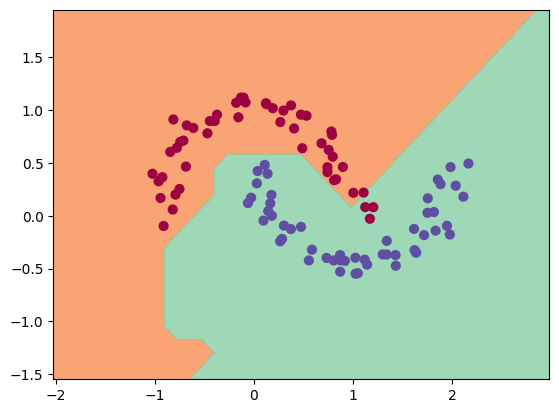

In [14]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Régularisation 

Un élément clé de l'apprentissage profond est la capacité du modèle à ne pas "overfit" les données d'entraînement. L'"overfitting" correspond à un modèle qui aurait trop bien appris sur les données d'entraînement mais qui ne serait pas capable de généraliser à de nouveaux élèments issus de la même distribution.  
Pour comprendre le principe, voici une figure faisant la différence entre underfitting (modèle trop simple), modèle bien entrainé et overfitting.  
<img src="images/overfitting.png" alt="overfitting" width="800"/>

Pour éviter le problème de l'overfitting, de nombreuses méthodes ont été proposées qui permettent de limiter la capacité d'apprentissage du modèle.  
Dans ce cours, nous allons voir une de ces méthodes.

### Régularisation L2

La régularisation L2 est une méthode qui consiste à ajouter une pénalité à la perte basée sur la valeur des poids du modèle. Cette pénalité est proportionnelle au carré des valeurs des poids du modèle (à noter qu'il existe aussi la régularisation L1 qui est linéairement proportionnelle au valeurs des poids du modèle). Cette pénalité encourage les poids du modèle à rester petits et moins sensibles au bruit des données d'entraînement.  
On peut formuler la régularisation L2 de cette manière :  
$L(w) = L_0(w) + \lambda \sum_{i=1}^{n} w_i^2$ où $L(w)$ est la perte régularisée, $L_0(w)$ est la fonction de perte classique, $\lambda$ est le coefficient de régularisation et $w_i$ est un poid du modèle.  
Pour en apprendre plus sur la régularisation, vous pouvez consulter ce [blogpost](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c). 

On peut implémenter la régularisation sur notre entraînement

In [16]:
def reg_loss(alpha=1e-4):
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    return reg_loss

In [ ]:
model = MLP(2, [16, 16, 1]) 
batch_size=64
iteration=50

In [17]:
for k in range(iteration):
    
    # On récupère notre mini-batch random
    inputs,labels=get_batch(batch_size=batch_size)

    # On fait appel au modèle pour calculer les scores Y
    scores = list(map(model, inputs))
    
    # On calcule le loss
    loss=loss_function(scores,labels)+reg_loss()


    accuracy = [(label > 0) == (scorei.data > 0) for label, scorei in zip(labels, scores)]
    accuracy=sum(accuracy) / len(accuracy)
    
    # Remise à zéro de valeurs de gradients avant de les calculer
    model.zero_grad() 
    # Calcul des gradients grâce à l'autograd de micrograd
    loss.backward() 
    
    # Mise à jour des poids avec les gradients calculés (SGD)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {loss.data}, accuracy {accuracy*100}%")

step 0 loss 0.09412845132607846, accuracy 95.3125%
step 1 loss 0.044114807309092875, accuracy 100.0%
step 2 loss 0.011350855527699868, accuracy 100.0%
step 3 loss 0.02294830392854534, accuracy 100.0%
step 4 loss 0.025372630456362233, accuracy 100.0%
step 5 loss 0.05852350090105026, accuracy 98.4375%
step 6 loss 0.026753319940565852, accuracy 100.0%
step 7 loss 0.022933856833355575, accuracy 100.0%
step 8 loss 0.04246452805777167, accuracy 98.4375%
step 9 loss 0.03234803618118133, accuracy 100.0%
step 10 loss 0.08840735899733446, accuracy 96.875%
step 11 loss 0.09667861115879708, accuracy 95.3125%
step 12 loss 0.03274744918548306, accuracy 100.0%
step 13 loss 0.06717499746552658, accuracy 96.875%
step 14 loss 0.016719087953303114, accuracy 100.0%
step 15 loss 0.01546360171844283, accuracy 100.0%
step 16 loss 0.01530248958453753, accuracy 100.0%
step 17 loss 0.019843732735080263, accuracy 100.0%
step 18 loss 0.03303979498158441, accuracy 100.0%
step 19 loss 0.02096189777095453, accuracy 

In [ ]:
# Visualisation de la frontière de décision 
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())